In [162]:
import pandas as pd
import plotly.express as px
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score
from typing import List, Tuple
from xgboost import XGBRegressor 
import uuid
import datetime 
import time
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit, GridSearchCV, train_test_split
from utils.output_analysis import plot_decision_tree_importance, plot_player_value_trends, save_output_tables


In [163]:
start = time.time()

In [164]:
pdf_mvp = pd.read_csv("data/intermediate/time_series_model_data_prep.csv") 

In [165]:
test_start = 2023
version  = "v0.0.3"

features = [
    "value_last_year",
    "age_last_year",
    "pos_Attack",
    "pos_Defender",
    "pos_Goalkeeper",
    "pos_Midfield",
    "contract_years_left",
]

subpos_features = [col for col in pdf_mvp.columns if col.startswith("subpos_")]
features += subpos_features

#test_players = pdf_mvp[pdf_mvp["year"] == test_start]["player_id"].unique()

train_df = pdf_mvp[(pdf_mvp["year"] < test_start)]
test_df = pdf_mvp[(pdf_mvp["year"] == test_start)]




In [166]:
def predict_future_values(
    train_df: pd.DataFrame,
    test_df: pd.DataFrame,
    prediction_years: List[int],
    features: List[str],
) -> tuple[pd.DataFrame, XGBRegressor, pd.Series]:
    """
    Predicts future player values for specified years using XGBoost.

    Args:
        train_df: Training DataFrame with features and target.
        test_df: Initial test DataFrame to predict from (starting year).
        prediction_years: List of years to predict, starting with the base year.
        features: List of feature column names to use.

    Returns:
        Tuple of:
            - DataFrame with predicted values for all prediction years concatenated.
            - Trained XGBRegressor.
            - y_test from the base year (only valid for the first year).
    """
    target = "market_value_in_million_eur"
    param_grid = {
        "n_estimators": [100, 200, 300],        # Number of boosting rounds (trees).
        "max_depth": [3, 5, 7],                 # Maximum depth of each tree.
        "learning_rate": [0.01, 0.1, 0.3],      # Step size shrinkage.
        "subsample": [0.7, 0.8, 1.0],           # Row sampling.
        "colsample_bytree": [0.7, 0.8, 1.0],    # Feature sampling.
        "gamma": [0, 1, 5],                     # Min loss reduction to make a split.
        "reg_alpha": [0, 0.1, 1],               # L1 regularization term.
        "reg_lambda": [0.1, 1, 10],             # L2 regularization term.
    }

    # Prepare training data
    X_train = train_df[features]
    y_train = train_df[target]

    # Define model and CV strategy
    xgb = XGBRegressor(random_state=42, objective="reg:squarederror")
    tscv = TimeSeriesSplit(n_splits=3)

    # Use GridSearchCV instead of RandomizedSearchCV
    regressor = GridSearchCV(
        estimator=xgb,
        param_grid=param_grid,
        scoring="neg_mean_squared_error",
        cv=tscv,
        verbose=1,
        n_jobs=-1
    )

    # Fit model
    regressor.fit(X_train, y_train)

    # Output best parameters
    print(f"Best parameters: {regressor.best_params_}")


    predictions = []
    current_df = test_df.copy()

    for i, year in enumerate(prediction_years):
        X_test = current_df[features]
        current_df["predicted_value"] = regressor.predict(X_test)
        current_df["year"] = year

        if i == 0:
            y_test = current_df[target]
            rmse = root_mean_squared_error(y_test, current_df["predicted_value"])
            r2 = r2_score(y_test, current_df["predicted_value"])
            print(f"{year} RMSE: {rmse:.2f}")
            print(f"{year} R²: {r2:.3f}")

            fig = px.scatter(current_df, x="predicted_value", y=target, hover_data=["name", "age"])
            fig.show()
        else:
            current_df["age"] = current_df["age_last_year"] + 1

        # Reduce contract years left by 1, never below 0
        if "contract_years_left" in current_df.columns:
            current_df["contract_years_left"] = (current_df["contract_years_left"] - 1).clip(lower=0)

        current_df["age_last_year"] = current_df["age"]
        current_df["value_last_year"] = current_df["predicted_value"]

        predictions.append(current_df[["player_id", "year", "age", "predicted_value"]].copy())

        if i < len(prediction_years) - 1:
            pos_cols = [col for col in current_df.columns if col.startswith("pos_")]
            subpos_cols = [col for col in current_df.columns if col.startswith("subpos_")]
            static_cols = pos_cols + subpos_cols

            carry_cols = ["player_id", "value_last_year", "age", *static_cols]
            if "contract_years_left" in current_df.columns:
                carry_cols.append("contract_years_left")
            current_df = current_df[carry_cols].copy()
            current_df.rename(columns={"age": "age_last_year"}, inplace=True)

    all_predictions_df = pd.concat(predictions, ignore_index=True)
    return all_predictions_df, regressor, y_test


In [167]:
forecast_df, regressor, y_test = predict_future_values(train_df, test_df, [2023, 2024, 2025, 2026, 2027, 2028], features)

Fitting 3 folds for each of 6561 candidates, totalling 19683 fits
Best parameters: {'colsample_bytree': 1.0, 'gamma': 5, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 10, 'subsample': 0.8}
2023 RMSE: 6.67
2023 R²: 0.823


In [168]:
# Merge with actual market values for evaluation

merged = forecast_df.merge(test_df[["player_id", "name"]], on=["player_id"], how="left")
end = time.time()
diff = end - start

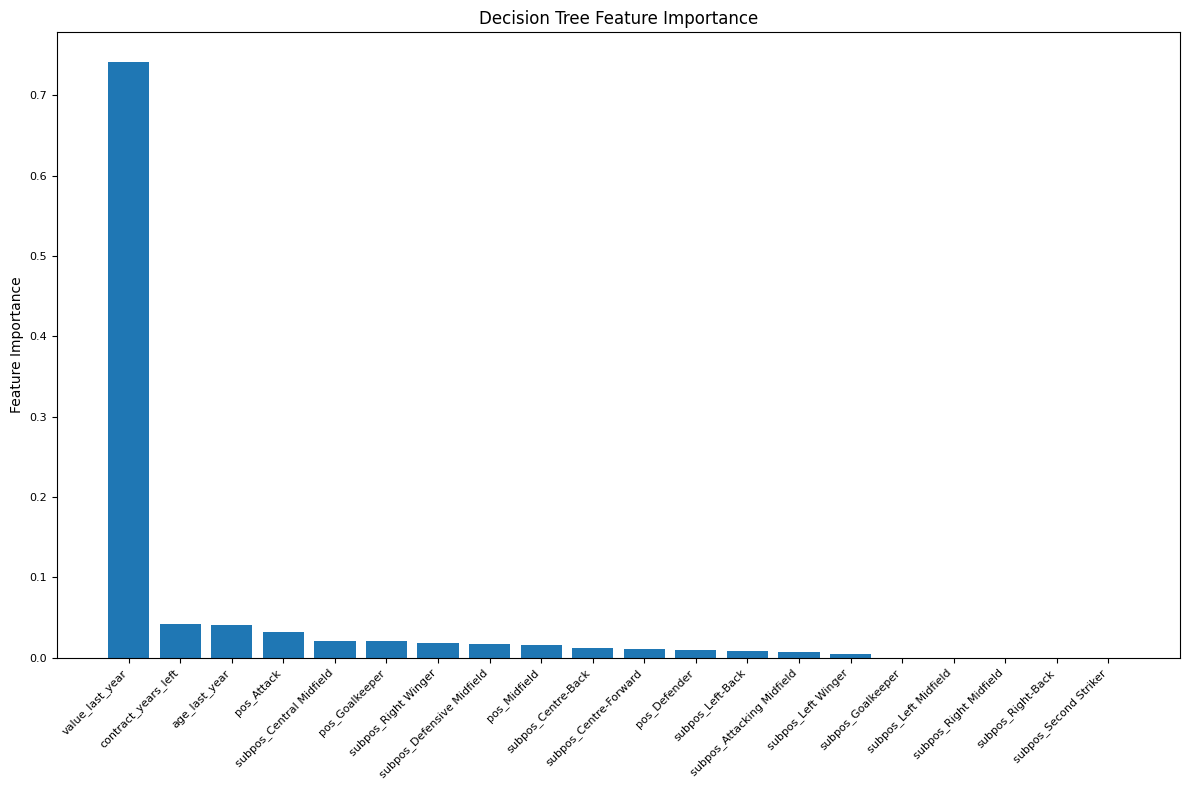

In [169]:
plot_decision_tree_importance(regressor.best_estimator_, features)

In [170]:
players = [418560, 357662, 565822, 859951, 148455, 274839, 542580, 568177]
plot_player_value_trends(train_df=train_df, merged_df=merged, player_ids=players)


In [171]:
output_df = merged.query("year == 2023")
output_df["actual_value"] = y_test.values


C:\Users\tomkn\AppData\Local\Temp\ipykernel_2016\2121820575.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [172]:
output_df["model_output_id"] = uuid.uuid4()
output_df["model_run_date"] = datetime.datetime.now()
output_df["time_taken_seconds"] = diff
output_df["features_used"] = str(features)
output_df["model_type"] = "XG_Boost"
output_df["split_year"] = test_start
output_df["version"] = version

C:\Users\tomkn\AppData\Local\Temp\ipykernel_2016\1487859311.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\tomkn\AppData\Local\Temp\ipykernel_2016\1487859311.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\tomkn\AppData\Local\Temp\ipykernel_2016\1487859311.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

In [173]:
save_output_tables(output_df)